# **Water Demand Forecasting**



In [1]:
#Basic Operations Libraries
import math
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
#Data Anaysis Libraries
import pandas as pd
import numpy as np
#Data Visulization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
#Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#Deep Learing Libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# Importing Dataset for analysis

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
martes = pd.read_excel('/content/drive/MyDrive/spain data (1).xlsx', sheet_name='martes_2')


Creating Timestamps

In [4]:
# creating timestamps for dataframe to sort them further
martes['timestamps'] = ['' for i in range(len(martes))]

for i in range(len(martes)):
  martes.timestamps[i] = martes.date[i] + ' ' + str(martes.h[i])
  martes['timestamps'][i] = datetime.strptime(martes['timestamps'][i], "%y/%m/%d %H:%M:%S")

In [5]:
martes = martes.sort_values(by = 'timestamps') # sorting values by time


In [6]:
martes

,item,demand,date,h,day,t,wind,mlsp,rain,timestamps
0,73,19.33,05/01/04,00:00:00,2,10.7,3.33,1037.8,2.7,2005-01-04 00:00:00
1,74,13.83,05/01/04,01:00:00,2,10.7,3.33,1037.8,2.7,2005-01-04 01:00:00
2,75,12.24,05/01/04,02:00:00,2,10.7,3.33,1037.8,2.7,2005-01-04 02:00:00
3,76,11.71,05/01/04,03:00:00,2,10.7,3.33,1037.8,2.7,2005-01-04 03:00:00
4,77,11.98,05/01/04,04:00:00,2,10.7,3.33,1037.8,2.7,2005-01-04 04:00:00
...,...,...,...,...,...,...,...,...,...,...
331,2276,14.17,05/04/05,19:00:00,2,15.9,5.00,1028.0,0.0,2005-04-05 19:00:00
332,2277,16.08,05/04/05,20:00:00,2,15.9,5.00,1028.0,0.0,2005-04-05 20:00:00
333,2278,20.84,05/04/05,21:00:00,2,15.9,5.00,1028.0,0.0,2005-04-05 21:00:00
334,2279,34.22,05/04/05,22:00:00,2,15.9,5.00,1028.0,0.0,2005-04-05 22:00:00


# Initial Data Inspection

In [7]:
martes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 335
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   item        336 non-null    int64  
 1   demand      336 non-null    float64
 2   date        336 non-null    object 
 3   h           336 non-null    object 
 4   day         336 non-null    int64  
 5   t           336 non-null    float64
 6   wind        336 non-null    float64
 7   mlsp        336 non-null    float64
 8   rain        336 non-null    float64
 9   timestamps  336 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 28.9+ KB


In [8]:
martes.describe().T 
# No null values found

,count,mean,std,min,25%,50%,75%,max
item,336.0,1176.500000,678.275117,73.00,588.7500,1176.500,1764.2500,2280.00
demand,336.0,17.918988,6.770344,3.51,13.6025,16.335,21.0825,40.27
day,336.0,2.000000,0.000000,2.00,2.0000,2.000,2.0000,2.00
t,336.0,10.678571,3.955063,5.40,7.2000,10.150,12.5000,17.70
wind,336.0,9.047857,5.922365,2.22,4.4400,6.295,13.1500,22.41
mlsp,336.0,1021.678571,8.443315,1007.90,1014.8000,1021.650,1027.4000,1037.80
rain,336.0,1.728571,3.824714,0.00,0.0000,0.000,0.0000,12.70


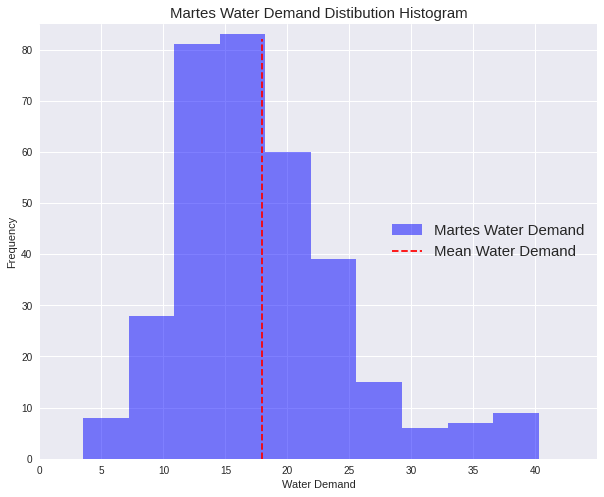

In [9]:
plt.style.use("seaborn")
plt.figure(figsize = (10,8)) #change size of graph
plt.hist(martes.demand, bins = 10, label = "Martes Water Demand", alpha = 0.5, color = "blue") #Histogramm of Water Demand Distibution martes
plt.vlines(sum(martes.demand)/len(martes.demand) ,0,82, color = "red", linestyle = "--", label = "Mean Water Demand") #vertical line at NY mean
plt.title("Martes Water Demand Distibution Histogram", fontsize = 15) #set title
plt.xlabel("Water Demand") #label x-axis
plt.ylabel("Frequency") #label y-axis
plt.xticks(range(0,45,5)) #set ticks of x-axis
plt.axis((0,45,0,85)) #set range of axis
plt.grid(True) #enable/disable grid
plt.legend(loc = "center right", fontsize = 15) #include legend
plt.show()

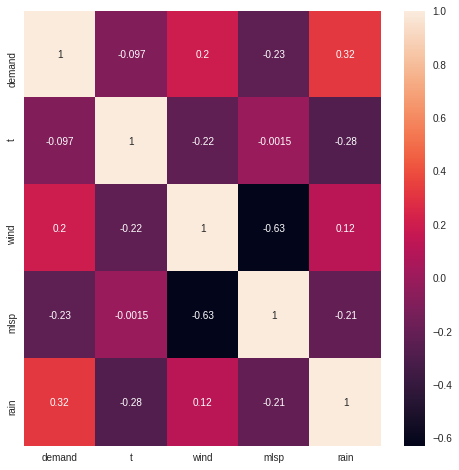

In [10]:
f, ax = plt.subplots(figsize = (8, 8))
sns.heatmap(martes.drop(['day', 'item'], axis = 1).corr(), annot = True)

# Data Preprocessing

In [11]:
data = martes.drop(['date', 'h','item', 'timestamps'], axis = 1)
data

,demand,day,t,wind,mlsp,rain
0,19.33,2,10.7,3.33,1037.8,2.7
1,13.83,2,10.7,3.33,1037.8,2.7
2,12.24,2,10.7,3.33,1037.8,2.7
3,11.71,2,10.7,3.33,1037.8,2.7
4,11.98,2,10.7,3.33,1037.8,2.7
...,...,...,...,...,...,...
331,14.17,2,15.9,5.00,1028.0,0.0
332,16.08,2,15.9,5.00,1028.0,0.0
333,20.84,2,15.9,5.00,1028.0,0.0
334,34.22,2,15.9,5.00,1028.0,0.0


In [12]:
data = data.astype(float)
data

,demand,day,t,wind,mlsp,rain
0,19.33,2.0,10.7,3.33,1037.8,2.7
1,13.83,2.0,10.7,3.33,1037.8,2.7
2,12.24,2.0,10.7,3.33,1037.8,2.7
3,11.71,2.0,10.7,3.33,1037.8,2.7
4,11.98,2.0,10.7,3.33,1037.8,2.7
...,...,...,...,...,...,...
331,14.17,2.0,15.9,5.00,1028.0,0.0
332,16.08,2.0,15.9,5.00,1028.0,0.0
333,20.84,2.0,15.9,5.00,1028.0,0.0
334,34.22,2.0,15.9,5.00,1028.0,0.0


In [13]:
demands = data['demand']
targets = list()

for i in range(len(demands)):
  if  i != 0:
    targets.append(demands[i])

targets.append(None)

In [14]:
data['Targets'] = targets

In [15]:
data

,demand,day,t,wind,mlsp,rain,Targets
0,19.33,2.0,10.7,3.33,1037.8,2.7,13.83
1,13.83,2.0,10.7,3.33,1037.8,2.7,12.24
2,12.24,2.0,10.7,3.33,1037.8,2.7,11.71
3,11.71,2.0,10.7,3.33,1037.8,2.7,11.98
4,11.98,2.0,10.7,3.33,1037.8,2.7,12.86
...,...,...,...,...,...,...,...
331,14.17,2.0,15.9,5.00,1028.0,0.0,16.08
332,16.08,2.0,15.9,5.00,1028.0,0.0,20.84
333,20.84,2.0,15.9,5.00,1028.0,0.0,34.22
334,34.22,2.0,15.9,5.00,1028.0,0.0,26.56


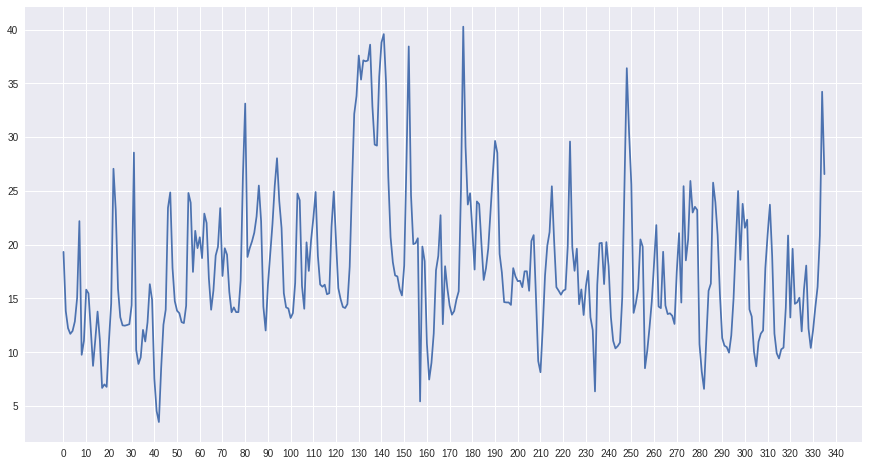

In [16]:
plt.figure(figsize = (15,8))
plt.xticks(ticks = range(0,350,10))
plt.plot(data['demand'])

In [17]:
# Remove the last row as it will be a null value
data = data[:-1]
data = data.loc[:, ['demand', 'wind', 'rain','mlsp', 'Targets']]

In [18]:
data = data.loc[:, ['demand','rain', 'Targets']]

In [19]:
data

,demand,rain,Targets
0,19.33,2.7,13.83
1,13.83,2.7,12.24
2,12.24,2.7,11.71
3,11.71,2.7,11.98
4,11.98,2.7,12.86
...,...,...,...
330,12.04,0.0,14.17
331,14.17,0.0,16.08
332,16.08,0.0,20.84
333,20.84,0.0,34.22


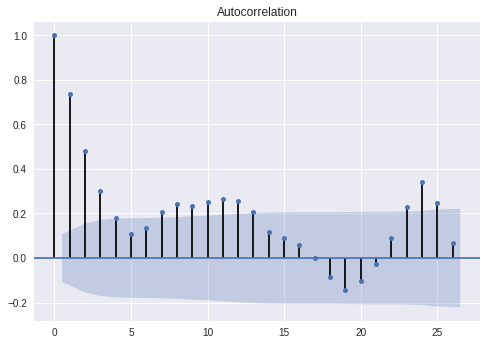

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
plot_acf(data['demand'])
pyplot.show()

In [21]:
# from above graph we get that we should look back upto 3 days to forecast next step

In [22]:
df1 = data.loc[:,['demand', 'rain']]
df1

,demand,rain
0,19.33,2.7
1,13.83,2.7
2,12.24,2.7
3,11.71,2.7
4,11.98,2.7
...,...,...
330,12.04,0.0
331,14.17,0.0
332,16.08,0.0
333,20.84,0.0


In [23]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,2))

In [24]:
df1.shape

(335, 2)

In [25]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:]

In [26]:
train_data.shape, test_data.shape

((217, 2), (118, 2))

In [27]:
targets = list(train_data[4:]) + list(test_data[4:])
len(targets)


327

In [28]:
targets

[array([0.23041349, 0.21259843]),
 array([0.25435256, 0.21259843]),
 array([0.31392818, 0.21259843]),
 array([0.50816104, 0.21259843]),
 array([0.17002176, 0.21259843]),
 array([0.20538629, 0.21259843]),
 array([0.33487486, 0.21259843]),
 array([0.32535365, 0.21259843]),
 array([0.23612622, 0.21259843]),
 array([0.14200218, 0.21259843]),
 array([0.20837867, 0.21259843]),
 array([0.27937976, 0.21259843]),
 array([0.20837867, 0.21259843]),
 array([0.08623504, 0.21259843]),
 array([0.09521219, 0.21259843]),
 array([0.08895539, 0.21259843]),
 array([0.20402612, 0.21259843]),
 array([0.30005441, 0.21259843]),
 array([0.640642  , 0.21259843]),
 array([0.53645267, 0.21259843]),
 array([0.33705114, 0.        ]),
 array([0.26523395, 0.        ]),
 array([0.2445593, 0.       ]),
 array([0.2437432, 0.       ]),
 array([0.24537541, 0.        ]),
 array([0.24755169, 0.        ]),
 array([0.29542982, 0.        ]),
 array([0.68144723, 0.        ]),
 array([0.18226333, 0.        ]),
 array([0.1468988,

In [29]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [30]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 3
X_train, y_train = create_dataset(train_data[:,0].reshape(-1,1), time_step)
X_test, ytest = create_dataset(test_data[:,0].reshape(-1,1), time_step)

In [31]:
X_train.shape

(213, 3)

In [32]:
X_test.shape

(114, 3)

In [33]:
y_train.shape

(213,)

In [34]:
ytest.shape

(114,)

In [35]:
X_train = np.append(X_train, train_data[time_step+1:,1].reshape(-1,1), axis = 1)
X_test = np.append(X_test, test_data[time_step+1:,1].reshape(-1,1), axis = 1)


In [36]:
X_train.shape, X_test.shape

((213, 4), (114, 4))

In [37]:

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# LSTM Based Model Building

In [38]:

model=Sequential()
model.add(LSTM(550,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(550,return_sequences=True))
model.add(LSTM(550))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [39]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 550)            1214400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 550)            2422200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 550)               2422200   
_________________________________________________________________
dense (Dense)                (None, 1)                 551       
Total params: 6,059,351
Trainable params: 6,059,351
Non-trainable params: 0
_________________________________________________________________


# Training The Model

In [40]:
 history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=150,batch_size=64,verbose=1)


Epoch 1/150
4/4 [==============================] - 9s 1s/step - loss: 0.1613 - val_loss: 0.1097
Epoch 2/150
4/4 [==============================] - 1s 379ms/step - loss: 0.0809 - val_loss: 0.0336
Epoch 3/150
4/4 [==============================] - 1s 376ms/step - loss: 0.0520 - val_loss: 0.0216
Epoch 4/150
4/4 [==============================] - 1s 371ms/step - loss: 0.0332 - val_loss: 0.0399
Epoch 5/150
4/4 [==============================] - 1s 378ms/step - loss: 0.0351 - val_loss: 0.0206
Epoch 6/150
4/4 [==============================] - 1s 364ms/step - loss: 0.0288 - val_loss: 0.0209
Epoch 7/150
4/4 [==============================] - 1s 373ms/step - loss: 0.0255 - val_loss: 0.0264
Epoch 8/150
4/4 [==============================] - 1s 370ms/step - loss: 0.0273 - val_loss: 0.0219
Epoch 9/150
4/4 [==============================] - 1s 375ms/step - loss: 0.0261 - val_loss: 0.0207
Epoch 10/150
4/4 [==============================] - 1s 374ms/step - loss: 0.0242 - val_loss: 0.0224
Epoch 11/150

In [41]:
plt.style.use("seaborn")

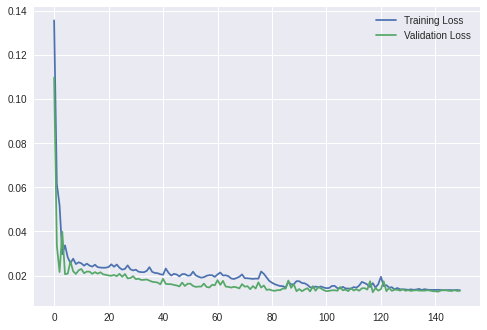

In [42]:
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()

In [43]:

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [44]:
(train_predict[:,0]).shape

(213,)

In [45]:
##Transformback to original form
train_predict= scaler.inverse_transform(np.repeat(train_predict, 2, axis = -1))
test_predict= scaler.inverse_transform(np.repeat(test_predict, 2, axis = -1))

train_predict = train_predict[:,0]
test_predict = test_predict[:,0]


Results

In [46]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

18.98189316000364

In [47]:

### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

16.84302739043652

In [48]:
Predicted = list(train_predict) + list(test_predict)

In [49]:
df_predicted = pd.DataFrame()

In [50]:
df_predicted['Targets'] = list(data['Targets'][3:216]) + list(data['Targets'][220:-1])

In [51]:
df_predicted['Predicted'] = Predicted

In [52]:
df_predicted

,Targets,Predicted
0,11.98,13.653911
1,12.86,13.791368
2,15.05,14.256540
3,22.19,15.050906
4,9.76,16.894047
...,...,...
322,12.04,13.048200
323,14.17,12.603465
324,16.08,15.043895
325,20.84,16.428516


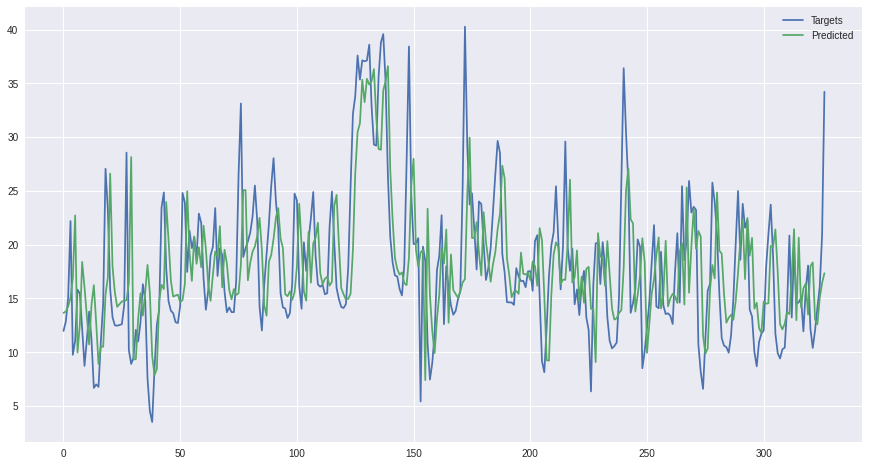

In [53]:
plt.style.use("seaborn")
plt.figure(figsize = (15,8))
plt.plot(df_predicted.index , df_predicted.loc[:, 'Targets'], label = "Targets")
plt.plot(df_predicted.index , df_predicted.loc[:, 'Predicted'], label = "Predicted")
plt.legend()
plt.show()

# Observations

1. Model conservatively predicts lower demands.
2. Model under predicts higher demands.
3. There is very less diffrence between training Data Loss and testing data loss(loss: RMSE) which shows model is not overfitting the data.